# Исследование рынка заведений общественного питания Москвы
***

# Описание проекта

Исследование рынка заведений общественного питания Москвы с целью определения перспективности инвестиций в небольшое кафе. Исследование проводится на открытых данных о заведениях общественного питания в Москве.

#### Описание данных для исследования

Данные получены из открытого источника - ["Портал открытых данных Правительства Москвы"](https://data.mos.ru/opendata/7710881420-obshchestvennoe-pitanie-v-moskve/data/table?versionNumber=1&releaseNumber=86). Исходя из сведний о заведениях в таблице, веротяно, данные представлены по состоянию на июль 2019 года.

- id — идентификатор объекта;
- object_name — название объекта общественного питания;
- chain — сетевой ресторан;
- object_type — тип объекта общественного питания;
- address — адрес;
- number — количество посадочных мест.

# Оглавление<a class='anchor' id='TOC'></a>

* **[I. Подготовка к анализу](#1)**
    - [1) Импортируем библиотеки, объявим классы для анализа](#1_1)
    - [2) Дополним данные из внешнего источника](#1_2)
    - [Вывод](#1_conclusion)
    
    
* **[2. Анализ данных](#2)**
    - [1) Исследуем соотношение видов объектов общественного питания по количеству](#2_1)
    - [2) Исследуем соотношение сетевых и несетевых заведений по количеству](#2_2)
    - [3) Проверим, можем ли мы рассматривать сетевые заведения и несетевые как одно явление¶](#2_3)
    - [4) Исследуем посадочные места в сетевых заведениях](#2_4)
    - [5) Исследуем расположение заведений](#2_5)
    - [6) Рекомендации о возможности развития сети](#2_6)
    - [Вывод](#2_conclusion)
<br></br>

**Презентация:** https://github.com/ikazman/practicum_da_projects/blob/main/market_research/market_research_presentation.pdf

# I. Подготовка к анализу<a class='anchor' id='1'></a>

## 1) Импортируем библиотеки, объявим классы для анализа<a class="anchor" id="1_1"></a>

In [1]:
import numpy as np
import pandas as pd
from solver.data_pipe import bootstrap, simple_grouper, upload_to_notebook
from solver.plotter import Picasso
from solver.stat_tests import NormalityCheck, Wilcoxon


### - прочитаем данные

In [2]:
df = pd.read_csv('datasets/rest_data.csv')

### - выведем первые пять первых и последних строк таблицы , общую информацию, статиcтику

In [3]:
display(df, df.info(),
        df[['number']].describe(percentiles=[.25, .5, .75, .99]).T,
        df.describe(include=['object']).T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
...,...,...,...,...,...,...
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36


None

,count,mean,std,min,25%,50%,75%,99%,max
number,15366.0,59.547182,74.736833,0.0,12.0,40.0,80.0,300.0,1700.0


,count,unique,top,freq
object_name,15366,10393,Столовая,267
chain,15366,2,нет,12398
object_type,15366,9,кафе,6099
address,15366,9108,"город Москва, Ходынский бульвар, дом 4",95


&#9889; **Выводы**
1. В датасете 15366 строк, без явных пропусков и проблем с данными.
2. Визуальное ознакомление проблем с датасетом не выявило.
3. Среднее число посадочных мест - 60, при медиане - 40, минимальное количество - 0, максимальное 1700. Максимальное значение оказывает давление на среднее.
4. Минимальное и максимальное проверим дополнительно - возможно, это ошибки в данных, неявные пропуски.
5. В представленных данных:
    - 267 наименований из 15 366 (1.7%) - "Столовая",
    - 12 398 из 15 366 (80%) - несетевые заведения, 
    - 6099 из 15 366 (39.6%)- кафе,
    - самый массовый адрес (95 заведений) - Москва, Ходынский бульвар, дом 4 (ТРК "Авиапарк"),
    - в 99% всех заведений не более 300 посадочных мест,
    - всего 9 типов заведений.

### - построим гистограмму, диаграммы рассеивания и размаха для числа посадочных мест

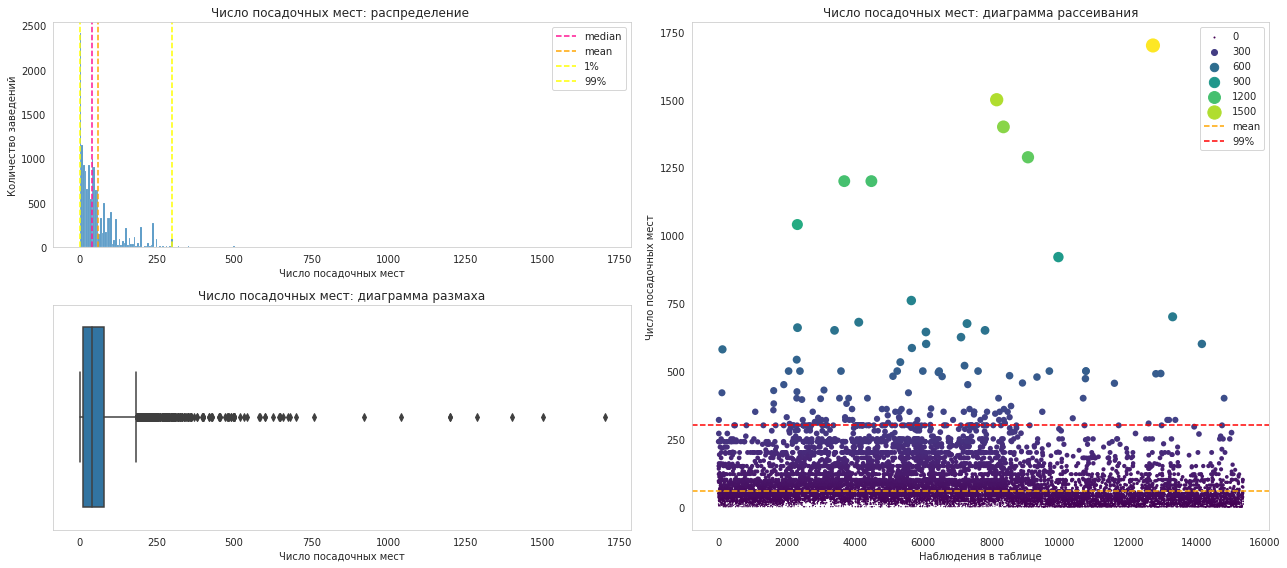

<Figure size 432x288 with 0 Axes>

In [4]:
Picasso.plotter(df, column='number',
                column_name='Число посадочных мест',
                y_label='Количество заведений',
                x_label='Число посадочных мест')

&#9889; **Выводы**

Есть выбросы, которые хорошо видны на диаграмме рассеивания и диаграмме размаха. Выбросы оказывает влияние на среднее. В целом, визуально не так много выбросов - вполне ожидаемо, что очень больших заведений не может быть слишком много и по экономическим причинам, и в силу отсутствия площадей.

### - проверим экстремальные значения в данных

В представленных данных число посадочных мест 99% заведений не превышает 300. Максимальное значение посадочных мест - 1700. Выведем заведения с числом посадочных мест более 300.

In [5]:
max_number = df.query('number > 300')
max_number

,id,object_name,chain,object_type,address,number
15,23663,Школа 1011,нет,столовая,"город Москва, улица Авиаторов, дом 18",320
105,24616,Сказка Востока,нет,ресторан,"город Москва, Коктебельская улица, дом 11, стр...",420
120,26075,МАКДОНАЛДС,да,предприятие быстрого обслуживания,"город Москва, Большая Бронная улица, дом 29",580
1080,27295,МУГАН,нет,ресторан,"город Москва, Соловьиный проезд, дом 6",350
1611,838,Темпл Бар,да,кафе,"город Москва, Первомайская улица, дом 33",356
...,...,...,...,...,...,...
13195,204172,СТОЛОВАЯ - КАНТИНАСИТИ,нет,буфет,"город Москва, Садовническая улица, дом 82, стр...",320
13299,200905,White Hall,нет,ресторан,"город Москва, Ферганская улица, дом 8",700
13378,155741,ПИЛЗНЕР,да,ресторан,"город Москва, 1-я Тверская-Ямская улица, дом 7",320
14155,207566,Столовая МИТ,нет,столовая,"город Москва, Берёзовая аллея, дом 10, корпус 1",600


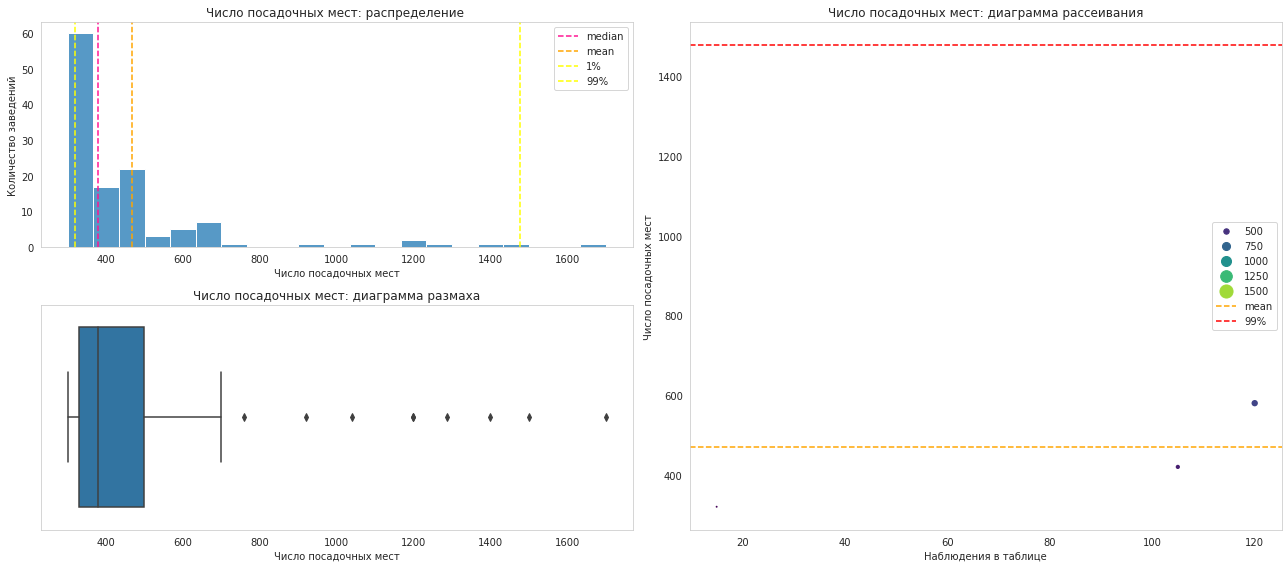

<Figure size 432x288 with 0 Axes>

In [6]:
Picasso.plotter(data=max_number,
                column='number',
                column_name='Число посадочных мест',
                y_label='Количество заведений',
                x_label='Число посадочных мест')

Всего 123 заведения (менее 1%), пик в районе 300 (около 60 заведений): в выборку попали и школьные столовые, и буфеты, и бары, и рестораны. Проверим максимальное значение:

In [7]:
max_number.query('number == 1700')

,id,object_name,chain,object_type,address,number
12723,199696,Arena by Soho Family,нет,бар,"город Москва, Кутузовский проспект, дом 36, ст...",1700


Arena by Soho Family - музыкальный клуб: количеством посадочных мест 1700, в сущности, названа полная вместимость клуба. Проверим минимальное значение посадочных мест - 0:

In [8]:
min_number = df.query('number == 0')
min_number

,id,object_name,chain,object_type,address,number
137,115498,Пекарня & Донер,нет,закусочная,"город Москва, Бутырская улица, дом 9, корпус 2",0
154,152556,Шаурма в пите,нет,предприятие быстрого обслуживания,"город Москва, Варшавское шоссе, дом 72, корпус 2",0
157,149568,Суши,нет,предприятие быстрого обслуживания,"город Москва, улица Маршала Василевского, дом ...",0
190,126956,"Шаурма, куры-гриль",нет,предприятие быстрого обслуживания,"город Москва, 1-я Владимирская улица, дом 21",0
195,149531,"Шаурма, куры-гриль",нет,предприятие быстрого обслуживания,"город Москва, 2-я Владимирская улица, дом 44/10",0
...,...,...,...,...,...,...
15334,211228,МИЛТИ,да,магазин (отдел кулинарии),"город Москва, Дубравная улица, дом 34/29",0
15335,211221,МИЛТИ,да,магазин (отдел кулинарии),"город Москва, Пятницкое шоссе, дом 3",0
15336,211209,Готовые блюда Милти,да,предприятие быстрого обслуживания,"город Москва, Ореховый бульвар, дом 22А",0
15337,208477,Милти,да,предприятие быстрого обслуживания,"город Москва, 3-й Крутицкий переулок, дом 18",0


Из 15 366 заведений 1621 (10.5%) без посадочных мест. Возможно, число посадочных мест зависит от типа заведений. Проверим:

In [9]:
simple_grouper(min_number, 'object_type')

,object_type,id,percent
6,предприятие быстрого обслуживания,704,43.43
3,кафе,310,19.12
2,закусочная,189,11.66
5,магазин (отдел кулинарии),145,8.95
4,кафетерий,113,6.97
1,буфет,68,4.19
7,ресторан,45,2.78
0,бар,28,1.73
8,столовая,19,1.17


Во всех категориях есть заведения без посадочных мест: больше всего предприятий быстрого обслуживания - 704 (43%), но есть и кафе - 310 (19.12%), и даже рестораны (45, 2.78%). Выведем случайные 15 строк с типом заведения "рестораны":

In [10]:
min_number.query('object_type == "ресторан"').sample(15)

,id,object_name,chain,object_type,address,number
12059,94219,Бургер Кинг,да,ресторан,"город Москва, Ходынский бульвар, дом 4",0
11602,177047,Ресторан «Суши Make»,нет,ресторан,"город Москва, Автозаводская улица, дом 18",0
12068,94597,KFC,да,ресторан,"город Москва, Ходынский бульвар, дом 4",0
8747,154514,Макдоналдс,да,ресторан,"город Москва, Хорошёвское шоссе, дом 27",0
15108,210192,Бургер Кинг,да,ресторан,"город Москва, поселение Московский, Киевское ш...",0
12896,200567,Гришаев В.В,нет,ресторан,"город Москва, Профсоюзная улица, дом 61А",0
4501,152255,Фудмаркет.Швыдкой,нет,ресторан,"город Москва, улица Новый Арбат, дом 21",0
15255,218284,Marmalato,да,ресторан,"город Москва, Хорошёвское шоссе, дом 27",0
14613,219023,Ресторан Ай дабаран,нет,ресторан,"город Москва, улица Вавилова, дом 3",0
4502,152222,Фудмаркет.Паритова,нет,ресторан,"город Москва, улица Новый Арбат, дом 21",0


По всей видимости, отсутствие посадочных мест не зависит от типа заведений, есть и рестораны, и столовые и кафе. Отчасти это вызвано самоидентификацией заведений в Москве: решение о выборе наименования предприятия, типа объекта, порядка и условий осуществления торговой деятельности, а также режима работы хозяйствующий субъект принимает самостоятельно (постановление Правительства РФ от 15.08.1997 г. № 1036 «Об утверждении правил оказания услуг общественного питания»). В результате, например, ресторанами может быть и фудмаркет, и Макдоналдс, и  KFC. Проверим, зависит ли отсутствие посадочных мест от адреса:

In [11]:
simple_grouper(min_number, 'address')

,address,id,percent
639,"город Москва, Ходынский бульвар, дом 4",47,2.90
529,"город Москва, Рождественский бульвар, дом 1",25,1.54
959,"город Москва, улица Новый Арбат, дом 21",20,1.23
509,"город Москва, Профсоюзная улица, дом 61А",16,0.99
646,"город Москва, Хорошёвское шоссе, дом 27",16,0.99
...,...,...,...
374,"город Москва, Митинская улица, дом 36",1,0.06
375,"город Москва, Митинская улица, дом 36, строение 1",1,0.06
376,"город Москва, Митинская улица, дом 40",1,0.06
377,"город Москва, Митинская улица, дом 45, корпус 2",1,0.06


Получили 1037 адресов: есть "массовые" адреса, но и есть адреса с одним заведением. Проверка пяти "массовых" адресов выявила, что заведения размещены в торгово-развлекательных центрах. Первые пять адресов с одним заведением размещены в отдельных изолированных точках и жилых домах.

&#9889; **Выводы**
1. Проверка экстремальных значений выявила, что в случае с максимальным значением - 1700 мест - речь идет о баре в музыкальном клубе, где под посадочными местами понимается полная вместимость клуба.
2. Отсутствие посадочных мест не зависит от типа заведения.
3. К столбцу с типом заведения следует относится с осторожностью, не установлено ограничительных критериев для отнесения к тому или иному типу данных - в соответствии с постановлением Правительства РФ от 15.08.1997 г. № 1036 «Об утверждении правил оказания услуг общественного питания» заведения самостоятельно выбирают типа объекта.
4. Выявлены "массовые" адреса заведений без посадочных мест - в торгово-развлекательных центрах. Как следствие, с некоторой осторожностью, можно утверждать, что отсутствие посадочных мест в данных связано с размещением на фудкортах, на которых совместно используют пространство несколько заведений, без фиксированного числа посадочных мест.
5. Выборочная проверка адресов с одним заведением выявила размещение в отдельно стоящих изолированных точках и жилых домах: местах, работающих "на вынос" - уличная еда.
6. В результате, нет достаточно оснований, чтобы считать 0 значения пропусками - значения являются частью явления. По крайней мере на данном этапе, принято решение сохранить данные в неизменном виде.


### - посчитаем дубликаты в данных

In [12]:
df[['id']].nunique()

id    15366
dtype: int64

Уникальные 15 366 id для каждого наблюдения в таблице. При проверке на дубликаты придется исключить - id, по ним выявить дубликаты не выйдет. Проверим дубликаты в данных по полям 'object_name', 'chain', 'object_type', 'address', 'number'.

In [13]:
subset = ['object_name', 'chain', 'object_type', 'address', 'number']
duplicated_mask = df.duplicated(subset=subset)
duplicated_mask.sum()

82

Всего 82 полных дубликата (менее 1%)). Представляется, что числом посадочных место можно пренебречь - сущностное значение имеет наименование, является ли заведение сетевым, тип заведения и адрес. Проверим дубликаты только по этим полям.

In [14]:
subset = ['object_name', 'chain', 'object_type', 'address']
duplicated_mask = df.duplicated(subset=subset)
duplicated_mask.sum()

170

Всего 170 из 15 366 (1%). Несущественное количество дубликатов. Посмотрим на дублированные записи:

In [15]:
df[duplicated_mask]

,id,object_name,chain,object_type,address,number
115,28614,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,буфет,"город Москва, Бригадирский переулок, дом 3-5",12
580,149205,Общественное питание,нет,кафе,"город Москва, Павелецкая площадь, дом 1",35
581,149131,Общественное питание,нет,кафе,"город Москва, Павелецкая площадь, дом 1",39
1409,151267,Альфорно,нет,кафе,"город Москва, город Зеленоград, корпус 438",45
2375,28604,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,столовая,"город Москва, 2-я Бауманская улица, дом 5, стр...",150
...,...,...,...,...,...,...
15173,218542,Кофе с собой,да,предприятие быстрого обслуживания,"город Москва, Алтуфьевское шоссе, дом 70, корп...",0
15216,214468,Макдоналдс,да,предприятие быстрого обслуживания,"город Москва, Варшавское шоссе, дом 87Б",0
15217,214146,Макдоналдс,да,предприятие быстрого обслуживания,"город Москва, Кировоградская улица, дом 13А",0
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20


&#9889; **Выводы**
1. Выявили 82 (менее 1%) полных дубликата по всем полям, кроме id.
2. Выявили 170 (1%) дубликатов по значениям 'object_name', 'chain', 'object_type', 'address'. 
3. Принято решение провести дополнительную проверку на дубликаты после обогащения данных из внешнего источника - оригинала - [портала открытых данных правительства Москвы](https://data.mos.ru/opendata/7710881420-obshchestvennoe-pitanie-v-moskve/data/table?versionNumber=1&releaseNumber=86), поскольку это может повлиять на количество дублированных записей.

[В оглавление](#TOC)

## 2) Дополним данные из внешнего источника<a class="anchor" id="1_2"></a>

### - общие сведения о данных из внешнего источника

Для обогащения данных были получены таблицы на [портале открытых данных правительства Москвы](https://data.mos.ru/opendata/7710881420-obshchestvennoe-pitanie-v-moskve/data/table?versionNumber=1&releaseNumber=86) за период от 2019 до 2022 года. Таблицы были объединены, число столбцов сокращено. В итоговом датасете 32 558 строк и 8 столбцов: 
- номер заведения (id), 
- наименование заведения (object_name), 
- округ Москвы (admo)
- район Москвы (district)
- адрес заведения (address)
- долготу (longitude)
- широту (latitude)
- oper_name_fixed (наименование заведения основанное на названии конкретного заведения и управляющей организации)

Код, использованный для подготовки данных, для справки размещен выше - класс OriginDataLoader.

### - загрузим данные

Передадим функции для загрузки id с таблицей и выведем результат

In [16]:
spreadsheet_id = '16i91OOAJ1ictLpQnyFgG_yhqE2otOzOyVlU5qelAeQA'
df_mos_ru = upload_to_notebook(spreadsheet_id)
df_mos_ru

,id,object_name,admo,district,address,longitude,latitude,oper_name_fixed
0,151635,СМЕТАНА,Северо-Восточный административный округ,Ярославский район,"город Москва, улица Егора Абакумова, дом 9",37.714565,55.879002,СМЕТАНА
1,77874,Родник,Центральный административный округ,Таганский район,"город Москва, улица Талалихина, дом 2/1, корпус 1",37.673306,55.738239,Родник
2,24309,Кафе «Академия»,Центральный административный округ,Таганский район,"город Москва, Абельмановская улица, дом 6",37.669648,55.735511,Кафе «Академия»
3,21894,ПИЦЦЕТОРИЯ,Северо-Восточный административный округ,район Лианозово,"город Москва, Абрамцевская улица, дом 1",37.573329,55.891957,Пиццетория
4,119365,Кафе «Вишневая метель»,Северо-Восточный административный округ,район Лианозово,"город Москва, Абрамцевская улица, дом 9, корпус 1",37.572306,55.904086,Кафе «Вишневая метель»
...,...,...,...,...,...,...,...,...
32553,344825,Андерсон,Северный административный округ,район Аэропорт,"Российская Федерация, город Москва, внутригоро...",37.532027,55.802104,Андерсон
32554,344162,Папа Джонс,Северо-Восточный административный округ,район Лианозово,"Российская Федерация, город Москва, внутригоро...",37.585711,55.894285,Папа Джонс
32555,344252,Кафе Пронто,Южный административный округ,район Нагатинский Затон,"город Москва, улица Новинки, дом 12Б",37.678746,55.676063,Кафе Пронто
32556,302175,Додо Пицца,Восточный административный округ,район Сокольники,"город Москва, Сокольническая площадь, дом 9",37.680485,55.790453,Додо Пицца


Поскольку данные сформированы из таблиц за 2019 - 2022 год, с целью максимального сохранения данных, объединение осуществлялось методом outer. Сбросим перед объединением дубликаты по id:

In [17]:
df_mos_ru.drop_duplicates('id', inplace=True)
df_mos_ru

,id,object_name,admo,district,address,longitude,latitude,oper_name_fixed
0,151635,СМЕТАНА,Северо-Восточный административный округ,Ярославский район,"город Москва, улица Егора Абакумова, дом 9",37.714565,55.879002,СМЕТАНА
1,77874,Родник,Центральный административный округ,Таганский район,"город Москва, улица Талалихина, дом 2/1, корпус 1",37.673306,55.738239,Родник
2,24309,Кафе «Академия»,Центральный административный округ,Таганский район,"город Москва, Абельмановская улица, дом 6",37.669648,55.735511,Кафе «Академия»
3,21894,ПИЦЦЕТОРИЯ,Северо-Восточный административный округ,район Лианозово,"город Москва, Абрамцевская улица, дом 1",37.573329,55.891957,Пиццетория
4,119365,Кафе «Вишневая метель»,Северо-Восточный административный округ,район Лианозово,"город Москва, Абрамцевская улица, дом 9, корпус 1",37.572306,55.904086,Кафе «Вишневая метель»
...,...,...,...,...,...,...,...,...
32553,344825,Андерсон,Северный административный округ,район Аэропорт,"Российская Федерация, город Москва, внутригоро...",37.532027,55.802104,Андерсон
32554,344162,Папа Джонс,Северо-Восточный административный округ,район Лианозово,"Российская Федерация, город Москва, внутригоро...",37.585711,55.894285,Папа Джонс
32555,344252,Кафе Пронто,Южный административный округ,район Нагатинский Затон,"город Москва, улица Новинки, дом 12Б",37.678746,55.676063,Кафе Пронто
32556,302175,Додо Пицца,Восточный административный округ,район Сокольники,"город Москва, Сокольническая площадь, дом 9",37.680485,55.790453,Додо Пицца


&#9889; **Выводы**
1. Получили датасет с 8 столбцами и 28301 строкой.
2. Датасет содержит:
    - номер заведения (id),
    - наименование заведения (object_name),
    - округ Москвы (admo)
    - район Москвы (district)
    - адрес заведения (address)
    - долготу (longitude)
    - широту (latitude)
    - унифицированное наименование (oper_name_fixed) - наименование заведения основанное на названии конкретного заведения и управляющей организации

### - объединим таблицы

In [18]:
merged_data = df.merge(df_mos_ru)
merged_data

,id,object_name,chain,object_type,address,number,admo,district,longitude,latitude,oper_name_fixed
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,Северо-Восточный административный округ,Ярославский район,37.714565,55.879002,СМЕТАНА
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,Центральный административный округ,Таганский район,37.673306,55.738239,Родник
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Центральный административный округ,Таганский район,37.669648,55.735511,Кафе «Академия»
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Северо-Восточный административный округ,район Лианозово,37.573329,55.891957,Пиццетория
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Северо-Восточный административный округ,район Лианозово,37.572306,55.904086,Кафе «Вишневая метель»
...,...,...,...,...,...,...,...,...,...,...,...
15360,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,Центральный административный округ,Таганский район,37.663848,55.731788,Шоколадница
15361,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10,Центральный административный округ,Басманный район,37.659150,55.757246,Шоколадница
15362,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20,Центральный административный округ,Басманный район,37.659150,55.757246,Шоколадница
15363,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36,Новомосковский административный округ,поселение Московский,37.436024,55.631768,Шоколадница


После объединения получили датасет с 11 столбцами и 15 365 строками.

### - избавимся от дубликатов в данных

Дубликаты будем искать по набору столбцов: унифицированное наименование ('oper_name_fixed'), является ли сетевым ('chain'), тип заведения ('object_type'), адрес ('address')

In [19]:
subset = ['oper_name_fixed', 'chain', 'object_type', 'address']

In [20]:
clean_data = merged_data.drop_duplicates(subset=subset).copy()
clean_data

,id,object_name,chain,object_type,address,number,admo,district,longitude,latitude,oper_name_fixed
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,Северо-Восточный административный округ,Ярославский район,37.714565,55.879002,СМЕТАНА
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,Центральный административный округ,Таганский район,37.673306,55.738239,Родник
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Центральный административный округ,Таганский район,37.669648,55.735511,Кафе «Академия»
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Северо-Восточный административный округ,район Лианозово,37.573329,55.891957,Пиццетория
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Северо-Восточный административный округ,район Лианозово,37.572306,55.904086,Кафе «Вишневая метель»
...,...,...,...,...,...,...,...,...,...,...,...
15358,222077,Кофейня «Шоколадница»,да,кафе,"город Москва, Кантемировская улица, дом 47",72,Южный административный округ,район Царицыно,37.656360,55.637803,Шоколадница
15359,219759,Шоколадница,да,кафе,"город Москва, улица Вавилова, дом 3",36,Южный административный округ,Донской район,37.592178,55.706986,Шоколадница
15360,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,Центральный административный округ,Таганский район,37.663848,55.731788,Шоколадница
15361,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10,Центральный административный округ,Басманный район,37.659150,55.757246,Шоколадница


Без дубликатов получили 15 186 строк: представляется, наблюдений достаточно для анализа.

### - для краткости переименуем типы заведений

Сократим "предприятие быстрого обслуживания" в "фастфуд", "магазин (отдел кулинарии)" в "кулинарию":

In [21]:
clean_data.replace({'предприятие быстрого обслуживания': 'фастфуд', 
                    'магазин (отдел кулинарии)': 'кулинария'}, inplace=True)

In [22]:
clean_data.query('object_type in ["кулинария", "фастфуд"]').sample(10)

,id,object_name,chain,object_type,address,number,admo,district,longitude,latitude,oper_name_fixed
14839,220000,Kalimera,нет,фастфуд,"город Москва, Ярцевская улица, дом 19",8,Западный административный округ,район Кунцево,37.411009,55.738664,Kalimera
12331,203616,Французская пекарня,нет,кулинария,"город Москва, Люсиновская улица, дом 4",2,Центральный административный округ,район Замоскворечье,37.622412,55.727353,Французская пекарня
2513,154248,Пицца «Паоло»,да,фастфуд,"город Москва, Медынская улица, дом 7",0,Южный административный округ,район Бирюлёво Западное,37.648219,55.586372,Пицца Паоло
5747,23521,KFC,да,фастфуд,"город Москва, Рязанский проспект, дом 75, корп...",48,Юго-Восточный административный округ,Рязанский район,37.794115,55.717559,KFC
11146,176260,Выпечка,нет,кулинария,"город Москва, бульвар Маршала Рокоссовского, д...",0,Восточный административный округ,район Богородское,37.715587,55.815635,Выпечка
13412,192981,СтардогS,да,фастфуд,"город Москва, Нижний Сусальный переулок, дом 5...",0,Центральный административный округ,Басманный район,37.665965,55.759313,СтардогS
12396,198263,Mr.Doner,нет,фастфуд,"город Москва, Тимирязевская улица, дом 17А",0,Северный административный округ,Тимирязевский район,37.567135,55.811824,Mr.Doner
7338,156898,Донер Кебаб,нет,фастфуд,"город Москва, Электролитный проезд, дом 7А, ст...",0,Южный административный округ,Нагорный район,37.612226,55.674322,Донер Кебаб
1291,153772,Хлеб-мясо на углях,нет,фастфуд,"город Москва, Хабаровская улица, дом 12/23",7,Восточный административный округ,район Гольяново,37.826774,55.821744,Хлеб-мясо на углях
13139,194582,Точка продажи готовой еды Милти,да,кулинария,"город Москва, Варшавское шоссе, дом 160",0,Южный административный округ,район Чертаново Южное,37.595139,55.582972,Милти


## Выводы<a class="anchor" id="2_conclusion"></a>

1. Получили данные с 15 366 наблюдениями, без проблем с типами данных, без явных пропусков.
2. С разумной степенью достоверности, неявные пропуски не выявлены.
3. Исходя из представленных данных:
    - среднее число посадочных мест - 60, 
    - медиана - 40,
    - минимальное количество - 0, 
    - максимальное 1700.
4. В представленных данных:
    - всего 9 типов заведений,
    - 267 из 15 366 (1.7%) наименований - "Столовая", 
    - 12 398 из 15 366 (80%) - несетевые заведения, 
    - 6099 из 15 366 (39.6%) наблюдений - кафе.
5. Самый массовый адрес (95 заведений) - Москва, Ходынский бульвар, дом 4 (ТРК "Авиапарк").
6. В 99% всех заведений не более 300 посадочных мест, всего в 123 (менее 1%) заведениях больше 300 посадочных мест. 
7. В 1 621 (10.5%) наблюдениях указаны 0 посадочных мест:
    - отсутствие посадочных мест не зависит от типа заведения, в том числе, по причине самоидентификации в силу постановления Правительства РФ от 15.08.1997 г. № 1036,
    - с некоторой осторожностью, можно утверждать, что отсутствие посадочных мест в данных связано с размещением на фудкортах, на которых совместно используют пространство несколько заведений, без финансированного числа посадочных мест,
    - выборочная проверка адресов с одним заведением выявила размещение в отдельно стоящих изолированных точках и жилых домах: местах, работающих "на вынос" - уличная еда,
    - нет достаточно оснований, чтобы считать 0 значения пропусками - значения являются частью явления.
8. Данные были обогащены из внешнего источника - Портала открытых данных Правительства Москвы (data.mos.ru): получены районы, административные округа, координаты заведения, унифицированное наименование.
9. После исключения дубликатов в объединенных данных получен датасет из 15 219 наблюдений, что составляет 99% от размера изначальных данных (15 366).
10. Для целей анализа и краткости переименованы "предприятие быстрого обслуживания" в "фастфуд", "магазин (отдел кулинарии)" в "кулинарию": 

[В оглавление](#TOC)

# II. Анализ данных<a class='anchor' id='2'></a>

## 1) Исследуем соотношение видов объектов общественного питания по количеству<a class="anchor" id="2_1"></a>

### - проверим соотношение видов объектов общественного питания в полученном датасете

In [23]:
simple_grouper(clean_data, 'object_type')

,object_type,id,percent
3,кафе,6012,39.59
7,столовая,2575,16.96
6,ресторан,2274,14.97
8,фастфуд,1889,12.44
0,бар,852,5.61
1,буфет,571,3.76
4,кафетерий,393,2.59
2,закусочная,348,2.29
5,кулинария,272,1.79


В представленных данных заметно выделяются четыре категории: с большим отрывом представлены кафе 6 012 (39.59%), далее идут столовые - 2 575 (16.96%), рестораны - 2 274 (14.97%), фастфуды - 1889 (12.44%). Остальные заведения занимают менее 6%: самый многочисленный тип - бары (852, 5.61%), менее всего в данных наблюдений об отделах кулинарии в магазинах (272, 1.79%).

### - визуализируем соотношение заведений

Для визуализации используем круговую диаграмму, по центру которой выведем наиболее представленный тип заведения: визуально подойдет под тематику исследования и пригодится для презентации - бейгл, бублик, пончик и так далее.

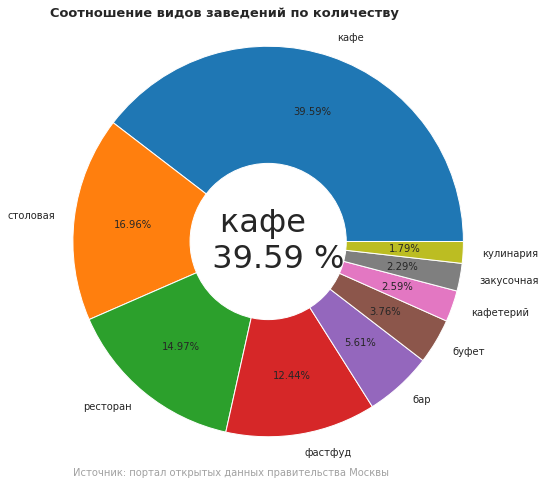

In [24]:
desciption = 'Cоотношение видов заведений по количеству'
Picasso.pie_chart_categories(clean_data, 'object_type', desciption)

&#9889; **Выводы**

1. В данных представлено 9 категорий - от отделов кулинарии в магазинах до ресторанов.
2. Заметно выделяются четыре категории: кафе 6 012 (39.59%), столовые - 2 575 (16.96%), рестораны - 2 274 (14.97%), фастфуды - 1889 (12.44%). Остальные заведения занимают менее 6%.

[В оглавление](#TOC)

## 2) Исследуем соотношение сетевых и несетевых заведений по количеству<a class="anchor" id="2_2"></a>

### - проверим  соотношение сетевых и несетевых заведений в данных

In [25]:
simple_grouper(clean_data, 'chain')

,chain,id,percent
1,нет,12244,80.63
0,да,2942,19.37


В представленных данных 80% (12 244) заведений - несетевые.

### - для какого вида объекта общественного питания характерно сетевое распространение

In [26]:
chained_types = clean_data.query('chain == "да"').copy()
chained_types_grouped = simple_grouper(chained_types, 'object_type')
chained_types_grouped

,object_type,id,percent
3,кафе,1384,47.04
8,фастфуд,782,26.58
6,ресторан,540,18.35
5,кулинария,78,2.65
2,закусочная,56,1.90
4,кафетерий,51,1.73
0,бар,37,1.26
1,буфет,11,0.37
7,столовая,3,0.10


Примечательно, что доля фастфуда от числа сетевых меньше, чем у кафе:
- кафе (47% от сетевых заведений),
- предприятия быстрого обслуживания (27% от сетевых заведений),
- рестораны (18% от сетевых заведений). 

На результат оказывает влияние количество наблюдений о кафе в данных - почти половина. Как следствие, чтобы оценить для каких заведений характерно сетевое распространение необходимо пересчитать долю сетевых заведений в каждом типе:

In [27]:
# отберем несетвые заведения
not_chained_types = clean_data.query('chain == "нет"')

# группируем данные о несетвых заведениях
not_chained_types_grpd = simple_grouper(not_chained_types, 'object_type')

# объединяем по двум столбцам сгруппированные данные о сетевых и несетевых
cols = ['object_type', 'id']
merged_chain = chained_types_grouped[cols].merge(not_chained_types_grpd[cols],
                                                 on='object_type')

# считаем долю сетевых
merged_chain['percent'] = round((merged_chain['id_x'] * 100 / 
                                (merged_chain['id_x'] + 
                                 merged_chain['id_y'])), 2)

# переименовываем столбцы
merged_chain.rename(columns={'id_x': 'chained',
                             'id_y': 'not_chained'}, inplace=True)

# выводим результат с сортировкой по процентам
merged_chain.sort_values(by='percent', ascending=False, inplace=True)
merged_chain

,object_type,chained,not_chained,percent
1,фастфуд,782,1107,41.40
3,кулинария,78,194,28.68
2,ресторан,540,1734,23.75
0,кафе,1384,4628,23.02
4,закусочная,56,292,16.09
5,кафетерий,51,342,12.98
6,бар,37,815,4.34
7,буфет,11,560,1.93
8,столовая,3,2572,0.12


В представленных данных сетевыми являются:
- 41% от всех фастфуда,
- 29% от всех отделов кулинарии,
- 24% от всех ресторанов,
- 16% от закусочных,
- 13% от кафетериев.

Визуализируем процент сетевых в каждом из типов заведений. При этом пренебрежем данными о столовых - менее 1% (3 из 2 572): на данном этапе, исходя из представленных данных, можно сделать вывод, что столовые можно рассматривать как типично несетевые заведения:

In [28]:
# отбросим столовые
merged_chain = merged_chain.query('percent > 1')

In [29]:
labels = {'bar_label': 'Сетевые заведения', 
          'xlabel': 'Тип заведения', 
          'ylabel': 'Проценты',
          'title': 'Процент сетевых заведений в каждом типе',
          'source': 'портал открытых данных правительства Москвы'}

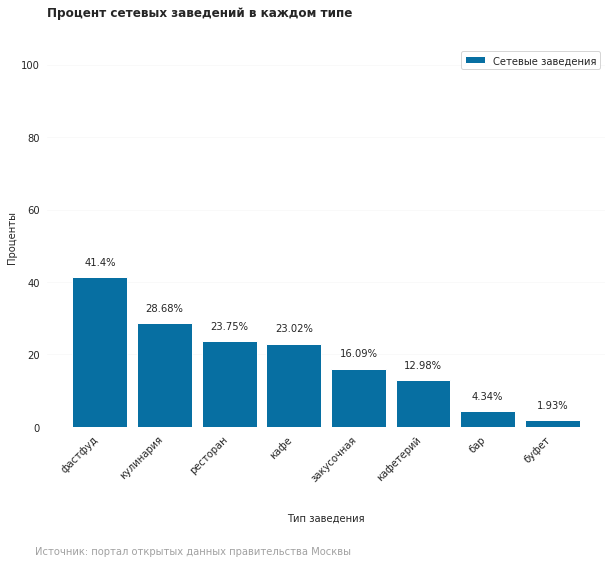

In [30]:
Picasso.percent_bar(merged_chain, 'object_type', labels=labels)

&#9889; **Выводы**

1. Для фастфуда характерно сетевое распространение - 41% от всех заведений данного типа. 
2. Кроме того, 29% от всех отделов кулинарии являются сетевыми - что, скорее, говорит о том, что магазины в которых они расположены являются сетевыми, также почти четверть ресторанов (24%) тоже являются сетевыми.
3. В принципе, во всех категориях есть сетевые заведения, но бары (4.34%), буфеты (1.93%) реже являются сетевыми, а столовые (0.12%) и вовсе редкость.

[В оглавление](#TOC)

## 3) Проверим, можем ли мы рассматривать сетевые заведения и несетевые как одно явление<a class="anchor" id="2_3"></a>

### - проверим статистику заведений

Полные данные:

In [31]:
clean_data[['number']].describe(percentiles=[0.95, 0.99]).T

,count,mean,std,min,50%,95%,99%,max
number,15186.0,59.911234,74.972612,0.0,40.0,217.75,300.0,1700.0


Проверим статистику сетевых заведений:

In [32]:
chained_types[['number']].describe(percentiles=[0.95, 0.99]).T

,count,mean,std,min,50%,95%,99%,max
number,2942.0,53.042148,57.253716,0.0,40.0,159.0,275.59,580.0


Проверим статистику несетевых заведений:

In [33]:
not_chained_types[['number']].describe(percentiles=[0.95, 0.99]).T

,count,mean,std,min,50%,95%,99%,max
number,12244.0,61.561745,78.549977,0.0,40.0,235.7,300.0,1700.0


&#9889; **Выводы**

Как ранее отмечалось, в 99% всех заведений не более 300 посадочных мест. В 95% всех заведений не более 218 посадочных мест. Если проверять отдельно сетевые и несетевые заведения - числовые средние двух выборок близки друг к другу, медиана совпадает. Вместе с тем, близость средних еще не говорит о принадлежности выборок одной и той же генеральной совокупности. 

[В оглавление](#TOC)

### - построим гистограммы с равным размером корзин:

In [34]:
labels = {'data1_name': 'Сетевые',
          'data2_name': 'Несетевые',
          'xlabel': 'Число посадочных мест', 
          'ylabel': 'Количество заведений',
          'title': 'Распределения числа посадочных мест'}

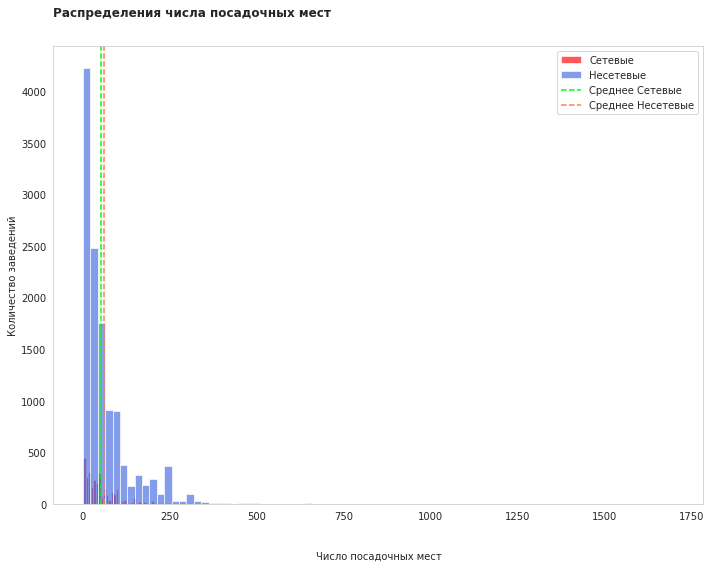

In [35]:
Picasso.overlaid_histogram(chained_types['number'],
                           not_chained_types['number'],
                           labels, n_bins=80)

Визуально распределения выборок похожи, средние почти сливаются. Ресемплируем данные и снова построим график:

In [36]:
labels = {'data1_name': 'Сетевые',
          'data2_name': 'Несетевые',
          'xlabel': 'Число посадочных мест', 
          'ylabel': 'Количество заведений',
          'title': 'Распределения числа посадочных мест на ресемплированных данных'}

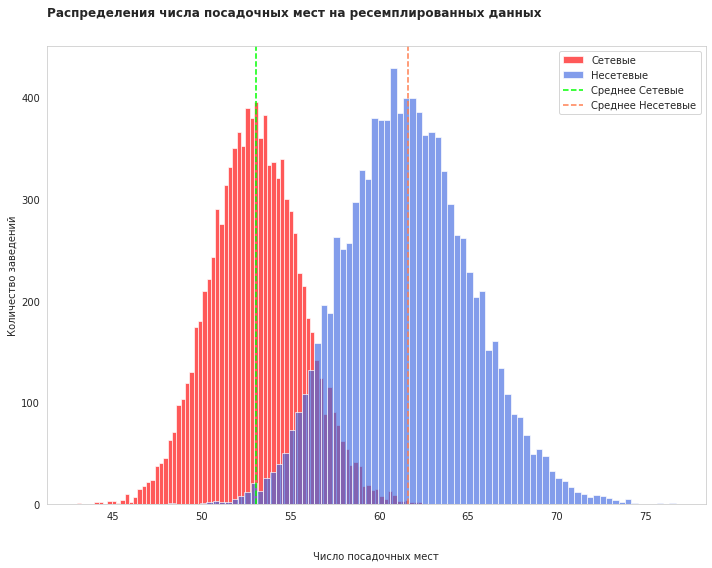

In [37]:
chained_resampled = bootstrap(chained_types['number'])
not_chained_resampled = bootstrap(not_chained_types['number'])

Picasso.overlaid_histogram(chained_resampled,
                           not_chained_resampled,
                           labels, n_bins=80)

&#9889; **Выводы**

После ресемплирования отчетливо видно, что среднее число посадочных мест у несетвых заведений выше, чем у сетевых. 

[В оглавление](#TOC)

### - проведем статистические тесты

Проверим верно ли визуальное наблюдение о ненормальности распределений двух выборок. Для этого проверим гипотезу для каждой из выборок - сетевой и несетевой - "выборка нормально распределена" по критерию Коломогорова-Смирнова.

1. Для выборки сетевых заведений:
    - нулевую гипотезу, которую проверяет тест, сформулируем так: "Выборка сетевых заведений нормально распределена",
    - альтернативную гипотезу, соответственно, сформулируем так: "Распределение выборки сетевых заведений не нормально",
    - примем уровень значимости в 5%. 


2. Для выборки несетевых заведений:
    - нулевую гипотезу, которую проверяет тест, сформулируем так: "Выборка несетевых заведений нормально распределена",
    - альтернативную гипотезу, соответственно, сформулируем так: "Распределение выборки несетевых заведений не нормально",
    - примем уровень значимости в 5%. 

In [38]:
samples = [chained_types['number'], not_chained_types['number']]
distr_test_result = NormalityCheck(samples).kolmogorov_smirnov()

(distr_test_result.style
                  .set_properties(**{'text-align': 'left'})
                  .set_table_styles([{'selector': 'th',
                                 'props': [('text-align','left')]}])
                  .format({'alpha': "{:.2f}", 'p-value < alpha': bool}))

,Выборка,Нулевая гипотеза (Н0),Альтернативная гипотеза (Н1),alpha,p-value,p-value < alpha,Н0/Н1
0,Сетевые заведения,Выборка сетевых заведений нормально распределена,Распределение выборки сетевых заведений не нормально,0.05,0.000000,True,Н1
1,Сетевые заведения,Выборка несетевых заведений нормально распределена,Распределение выборки несетевых заведений не нормально,0.05,0.000000,True,Н1


&#9889; **Выводы**

В отношении распределений выборок по сетевым и несетевым заведениям, исходя из представленных данных, на уровне значимости 5% - есть основания отвергнуть нулевую гипотезу в пользу альтернативы: распределение выборок сетевых и несетевых заведений не нормально. Таким образом, результаты статистического теста соответствует визуальным наблюдениям. 

[В оглавление](#TOC)

### - проверим гипотезу "Средние число посадочных мест в сетевых и несетевых заведениях одинаковые"

Поскольку в нашем случае, в данных есть большие (по сравнению с нормальным распределением) выбросы, данные распределены не нормально - к выборкам будет применен непараметрический статистический критерий.
При этом, поскольку заведения, независимо от того, являются ли они сетевыми или нет - влияют друг на друга, работают с более или менее одними поставщиками, арендодателями, оказывают услуги одним и тем же клиентам: поэтому выборки следует рассматривать как зависимые.
В результате к выборкам будет применен непараметрический статистический критерий Уилкоксона для проверки гипотезы "Средние число посадочных мест в сетевых и несетевых заведениях одинаковые":


   1. Тест будет проведен по полным и сокращенным данным (без выбросов).
<br></br>  
   2. Перед проведением тестов из полных данных исключены выбросы, верхняя граница числа посадочных мест установлена на 99-ом перцентиле (300 посадочных мест).
<br></br>  
   3. К полученным выборкам будет применен статистический критерий Уилкоксона.
<br></br>  
   4. Для полных и сокращенных данных конверсии проверим гипотезу "Средние число посадочных мест в сетевых и несетевых заведениях одинаковые":
        - нулевую гипотезу, которую проверяет тест, сформулируем так: "В числе посадочных мест нет различий",
        - альтернативную гипотезу, соответственно, сформулируем так: "В числе посадочных мест есть различия",
        - примем уровень значимости в 5%.


In [39]:
tests_result = Wilcoxon(chained_types, not_chained_types,
                        clean_data, num_limit=275).wilcoxon_stat()

(tests_result.style
             .set_properties(**{'text-align': 'left'})
             .set_table_styles([{'selector': 'th',
                                 'props': [('text-align','left')]}])
             .format({'alpha': "{:.2f}", 'p-value < alpha': bool}))

,Выборка,Нулевая гипотеза (Н0),Альтернативная гипотеза (Н1),alpha,p-value,p-value < alpha,Н0/Н1
0,Среднее число мест по сырым,В числе посадочных мест нет различий,В числе посадочных мест есть различия,0.05,0.000000,True,Н1
1,Среднее число мест по очищенным,В числе посадочных мест нет различий,В числе посадочных мест есть различия,0.05,0.000000,True,Н1


&#9889; **Выводы**


1. В отношении различий числа посадочных мест между сетевыми и несетевыми заведениями (и по полным, и по очищенным от аномалий выборкам), исходя из представленных данных, на уровне значимости 5% - есть основания отвергнуть нулевую гипотезу в пользу альтернативы: среднее число мест имеет статистически значимые различия.
2. Принимая во внимание общую статистку, визуальное представление и результаты статистических тестов есть основания рассматривать сетевые и несетевые заяведения как самостоятельные явления - сетевые заведения отличаются от несетевых.

[В оглавление](#TOC)

## 4) Исследуем посадочные места в сетевых заведениях<a class="anchor" id="2_4"></a>

### - посчитаем количество завдений в каждой сети

Сгруппируем данные по названию сети и посчитаем число заведений в каждой сети:

In [40]:
grouped_chained = simple_grouper(chained_types, 'oper_name_fixed')
grouped_chained

,oper_name_fixed,id,percent
272,Шоколадница,178,6.05
22,KFC,175,5.95
159,Макдоналдс,168,5.71
73,Бургер Кинг,158,5.37
246,Теремок,110,3.74
...,...,...,...
187,Песто,1,0.03
186,Перекресток,1,0.03
81,Виват-Пицца,1,0.03
82,Виктория,1,0.03


&#9889; **Выводы**

1. Пять самых крупных сетей:
    - Шоколадница (178 заведений, 6.05% от числа сетевых заведений,
    - KFC (175 заведений, 5.95% от числа сетевых заведений),
    - Макдоналдс (168 заведений, 5.71% от числа сетевых заведений),
    - Бургер Кинг (158 заведений, 5.37% от числа сетевых заведений),
    - Теремок (111 заведений, 3.74% от числа сетевых заведений).
<br></br>
2. Есть сети с одним заведением - возможно, сведения не о всех заведениях попали в данные.

[В оглавление](#TOC)

### - добавим в группированные данные среднее число мест на сеть

Посчитаем сколько в среднем посадочных мест в каждом из сетевых заведений:

In [41]:
chained_types['number_mean'] = (chained_types
                                .groupby('oper_name_fixed', as_index=False)['number']
                                .transform(lambda x: np.mean(x.values)))

In [42]:
chained_types.sample(5)

,id,object_name,chain,object_type,address,number,admo,district,longitude,latitude,oper_name_fixed,number_mean
828,134362,Travelers Coffee,да,кафе,"город Москва, улица Остоженка, дом 14/2",27,Центральный административный округ,район Хамовники,37.598869,55.741907,Travelers Coffee,24.500000
15270,211210,Милти,да,кафе,"город Москва, Колодезный переулок, дом 3",0,Восточный административный округ,район Сокольники,37.697460,55.798206,Милти,1.185185
9235,119862,Грузинская кухня ЭZО Хинкальная,да,ресторан,"город Москва, улица Арбат, дом 31",90,Центральный административный округ,район Арбат,37.592959,55.749689,Хинкальная,56.090909
8049,25167,МУ-МУ,да,кафе,"город Москва, Комсомольский проспект, дом 26",300,Центральный административный округ,район Хамовники,37.581144,55.727592,Му-Му,156.875000
4586,75239,Территория,да,ресторан,"город Москва, Рязанский проспект, дом 64",150,Юго-Восточный административный округ,район Выхино-Жулебино,37.804009,55.714507,Территория,98.500000


In [43]:
grouped_chained = grouped_chained.merge(chained_types[['oper_name_fixed', 'number_mean']],
                                        on='oper_name_fixed', how='left')

grouped_chained.drop_duplicates(inplace=True)
grouped_chained

,oper_name_fixed,id,percent,number_mean
0,Шоколадница,178,6.05,58.370787
178,KFC,175,5.95,54.977143
353,Макдоналдс,168,5.71,88.982143
521,Бургер Кинг,158,5.37,48.360759
679,Теремок,110,3.74,27.254545
...,...,...,...,...
2937,Песто,1,0.03,80.000000
2938,Перекресток,1,0.03,1.000000
2939,Виват-Пицца,1,0.03,42.000000
2940,Виктория,1,0.03,98.000000


&#9889; **Выводы**

В пяти самых крупных сетях среднее число посадочных мест:
- Шоколадница - 58,
- KFC - 54,
- Макдоналдс - 89,
- Бургер Кинг - 48,
- Теремок - 27.


### - построим диаграмму рассеивания и плотности по числу заведений и количеству посадочных мест

In [44]:
labels = {'xlabel': 'Количество заведений в сети', 
          'ylabel': 'Среднее число посадочных мест',
          'title': 'Отношение количества заведений к посадочным местам: диаграммы рассеивания и плотности',
          'source': 'портал открытых данных правительства Москвы'}

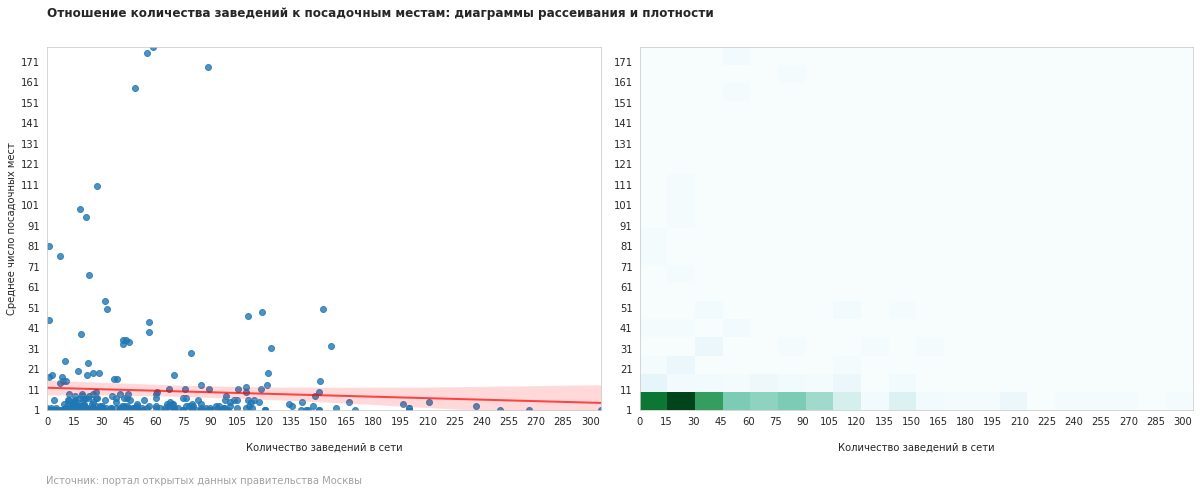

In [45]:
Picasso.density_plotter(grouped_chained, ['number_mean', 'id'], labels)

Проверим корреляцию между числом заведений и количеством мест:

In [46]:
grouped_chained[['number_mean', 'id']].corr()

,number_mean,id
number_mean,1.00000,-0.05081
id,-0.05081,1.00000


&#9889; **Выводы**

Можно было бы логарифмировать значения по среднему числу мест, но и так видно, что линия регрессии наклонена вправо, слабая корреляция между двумя значениями - увеличение числа заведений оказывает незначительное отрицательное давление на среднее число мест. На диаграмме плотности заметно, что большинство сетевых заведений представлено в количестве от 1 до 10, чаще всего с числом посадочных мест в диапазоне от 15 до 30, чуть реже менее 15 и более 45. Чтобы понять много это или мало - сегментируем сети, разделив заведения по корзинам.

[В оглавление](#TOC)

### - сегментируем сетевые заведения

Поскольку "мало" и "много" относительные понятия и, в нашем случае, метрика числа мест и количества заведений может быть рассчитана относительно самого себя, разделим сетевые заведения на три равные корзины в каждом из измерений (количество заведений и мест) - маленькие, средние, большие, а затем проверим в какую попадет большинство.

Для простоты используем три ярлыка 1 - для маленьких, 2 - средних, 3 - для больших значений:

In [47]:
grouped_chained

,oper_name_fixed,id,percent,number_mean
0,Шоколадница,178,6.05,58.370787
178,KFC,175,5.95,54.977143
353,Макдоналдс,168,5.71,88.982143
521,Бургер Кинг,158,5.37,48.360759
679,Теремок,110,3.74,27.254545
...,...,...,...,...
2937,Песто,1,0.03,80.000000
2938,Перекресток,1,0.03,1.000000
2939,Виват-Пицца,1,0.03,42.000000
2940,Виктория,1,0.03,98.000000


In [48]:
grouped_chained['number_sizes'] = pd.cut(grouped_chained['number_mean'], bins=3, labels=[1, 2, 3])
grouped_chained['id_size'] = pd.cut(grouped_chained['id'], bins=3, labels=[1, 2, 3])
grouped_chained

,oper_name_fixed,id,percent,number_mean,number_sizes,id_size
0,Шоколадница,178,6.05,58.370787,1,3
178,KFC,175,5.95,54.977143,1,3
353,Макдоналдс,168,5.71,88.982143,1,3
521,Бургер Кинг,158,5.37,48.360759,1,3
679,Теремок,110,3.74,27.254545,1,2
...,...,...,...,...,...,...
2937,Песто,1,0.03,80.000000,1,1
2938,Перекресток,1,0.03,1.000000,1,1
2939,Виват-Пицца,1,0.03,42.000000,1,1
2940,Виктория,1,0.03,98.000000,1,1


In [49]:
chained_binned = simple_grouper(grouped_chained,
                                'number_sizes',
                                agg_dict={'id_size': 'count'})

chained_binned.replace({1: 'Мало', 2: 'Средне', 3: 'Много'}, inplace=True)
chained_binned.columns = ['Корзина', 'Количество']
chained_binned['Процент'] = (round(chained_binned['Количество'] * 100 / 
                                   chained_binned['Количество'].sum(), 2))
(chained_binned.set_index('Корзина').style
                                    .set_properties(**{'text-align': 'left'})
                                    .set_table_styles([{'selector': 'th',
                                                        'props': [('text-align','left')]}]))

,Количество,Процент
Корзина,,
Мало,235,83.040000
Средне,43,15.190000
Много,5,1.770000


&#9889; **Выводы**

1. Из сетевых заведений 83% (235) попали в корзину с относительно малым количеством и мест и заведений, 15% (43) попали в среднюю, и только 1.7% попали в корзину с множеством мест и заведений.
2. Принимая во внимание полученный результат, с некоторой осторожностью, можно сделать вывод: поскольку выявлено, что большинство сетевых заведений представлено в количестве от 1 до 10, чаще всего с числом посадочных мест в диапазоне от 15 до 45, то несмотря на несколько доминирующих сетей - в целом, большинство сетей оперируют сравнительно небольшим числом посадочных мест и количеством заведений.

[В оглавление](#TOC)

### - среднее количество посадочных мест в зависимости от типа заведения

Посчитаем среднее число посадочных мест в зависимости от типа заведения по всем данным:

In [50]:
mean_num_by_type = (simple_grouper(clean_data, 'object_type', {'number': ['mean', 'median']})
                    .droplevel(level=1, axis=1)
                    .reset_index(drop=True))

mean_num_by_type.columns = ['object_type', 'mean_number', 'median_number']
mean_num_by_type.sort_values(by='mean_number', ascending=False)

,object_type,mean_number,median_number
7,столовая,130.367767,103.0
6,ресторан,97.063764,80.0
1,буфет,51.572680,32.0
0,бар,43.611502,35.0
3,кафе,39.874251,32.0
8,фастфуд,20.776072,6.0
4,кафетерий,9.221374,6.0
2,закусочная,7.663793,0.0
5,кулинария,5.610294,0.0


С отрывом в столовых и ресторанах, в среднем, больше всего посадочных мест: в столовых 130 (при медиане 103), в ресторанах 97 (при медиане 80), далее выделяется группа буфет-бар-кафе-фастфуд с средним числом посадочных мест от 51 до 20 (у бара кафе, буфета медиана близка, у фастфуда - 6 мест). Посчитаем среднее число посадочных мест в зависимости от типа заведения по сетевым заведениям:

In [51]:
mean_chain_num_by_type = (simple_grouper(chained_types, 'object_type', 
                                         {'number': ['mean', 'median']})
                          .droplevel(level=1, axis=1)
                          .reset_index(drop=True))

mean_chain_num_by_type.columns = ['object_type', 'mean_number', 'median_number']
mean_chain_num_by_type = mean_chain_num_by_type.sort_values(by='mean_number', ascending=False)
mean_chain_num_by_type

,object_type,mean_number,median_number
7,столовая,112.333333,120.0
6,ресторан,100.609259,89.5
0,бар,53.027027,45.0
3,кафе,47.412572,40.0
8,фастфуд,40.336317,25.0
2,закусочная,14.375000,8.0
1,буфет,12.727273,0.0
4,кафетерий,12.509804,8.0
5,кулинария,8.679487,3.5


In [52]:
labels = {'xlabel': 'Тип заведения', 
          'ylabel': 'Число посадочных мест',
          'title': 'Среднее число посадочных мест в зависимости от типа',
          'source': 'портал открытых данных правительства Москвы'}

<Figure size 720x720 with 0 Axes>

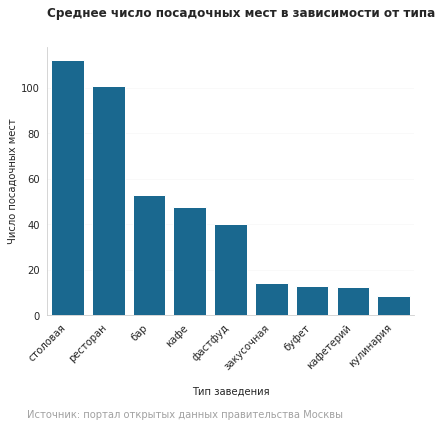

In [53]:
Picasso.sns_catplot(data=mean_chain_num_by_type,
                    columns=['object_type', 'mean_number'],
                    labels=labels)

В сетевых заведениях также с отрывом лидируют столовые и рестораны - 112 (при медиане 120), 100 (при медиане 90), соответственно. В отношении других типов -  выделяется группа бар-кафе-фастфуд со средним в диапазоне от 53 до 40.

&#9889; **Выводы**

1. Тип заведения влияет на среднее количество мест.
2. С отрывом больше, в среднем, мест в столовых и ресторанах - 112 (при медиане 120), 100 (при медиане 90), соответственно.
3. Кроме того, выделяется группа бар-кафе-фастфуд со средним в диапазоне от 53 до 40.

[В оглавление](#TOC)

## 5) Исследуем расположение заведений<a class="anchor" id="2_5"></a>

### - выделим улицы из адреса

К улицам сразу добавим и города:

In [54]:
splited_adress = clean_data['address'].str.split(',', expand=True)
clean_data['city'] = splited_adress[0]
clean_data['street'] = splited_adress[1]
clean_data

,id,object_name,chain,object_type,address,number,admo,district,longitude,latitude,oper_name_fixed,city,street
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,Северо-Восточный административный округ,Ярославский район,37.714565,55.879002,СМЕТАНА,город Москва,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,Центральный административный округ,Таганский район,37.673306,55.738239,Родник,город Москва,улица Талалихина
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Центральный административный округ,Таганский район,37.669648,55.735511,Кафе «Академия»,город Москва,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Северо-Восточный административный округ,район Лианозово,37.573329,55.891957,Пиццетория,город Москва,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Северо-Восточный административный округ,район Лианозово,37.572306,55.904086,Кафе «Вишневая метель»,город Москва,Абрамцевская улица
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15358,222077,Кофейня «Шоколадница»,да,кафе,"город Москва, Кантемировская улица, дом 47",72,Южный административный округ,район Царицыно,37.656360,55.637803,Шоколадница,город Москва,Кантемировская улица
15359,219759,Шоколадница,да,кафе,"город Москва, улица Вавилова, дом 3",36,Южный административный округ,Донской район,37.592178,55.706986,Шоколадница,город Москва,улица Вавилова
15360,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,Центральный административный округ,Таганский район,37.663848,55.731788,Шоколадница,город Москва,3-й Крутицкий переулок
15361,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10,Центральный административный округ,Басманный район,37.659150,55.757246,Шоколадница,город Москва,улица Земляной Вал


Проверим, корректно ли разделили адреса:

In [55]:
streets_need_to_correct = clean_data.query('city != "город Москва"')
streets_need_to_correct

,id,object_name,chain,object_type,address,number,admo,district,longitude,latitude,oper_name_fixed,city,street
859,23601,Буфет - ГБОУ СОШ № 64,нет,буфет,"Партизанская улица, дом 30",100,Западный административный округ,район Кунцево,37.412814,55.736482,Буфет - ГБОУ СОШ № 64,Партизанская улица,дом 30
860,23604,Буфет - ГБОУ 60,нет,буфет,"Партизанская улица, дом 30",100,Западный административный округ,район Кунцево,37.412814,55.736482,Буфет - ГБОУ 60,Партизанская улица,дом 30
1491,25349,Ресторан «Гранатовый сад»,нет,ресторан,"Поречная улица, дом 5/14, строение 1",40,Юго-Восточный административный округ,район Марьино,37.752868,55.644912,Ресторан «Гранатовый сад»,Поречная улица,дом 5/14
7691,132359,Кафе «La Carotte»,нет,кафе,"1-й Нагатинский проезд, дом 10",198,Южный административный округ,район Нагатино-Садовники,37.631322,55.678497,Кафе «La Carotte»,1-й Нагатинский проезд,дом 10
7827,28214,Роснефть (закрытое),нет,столовая,"Софийская набережная, дом 26/1, строение 1",80,Центральный административный округ,район Якиманка,37.619768,55.747691,Роснефть (закрытое),Софийская набережная,дом 26/1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13184,192918,Limassol,нет,кафе,"Бауманская улица, дом 7, строение 3",42,Центральный административный округ,Красносельский район,37.659232,55.771282,Limassol,Бауманская улица,дом 7
13398,204788,Крошка Картошка,да,фастфуд,"Солянский тупик, дом 1/4, строение 1",15,Центральный административный округ,Таганский район,37.636117,55.753580,Крошка Картошка,Солянский тупик,дом 1/4
13990,204917,Шаурма на углях- Чайхана Баракат,нет,кафе,"Таганская площадь, дом 88, строение 4",80,Центральный административный округ,Таганский район,37.652145,55.741064,Шаурма на углях- Чайхана Баракат,Таганская площадь,дом 88
14002,211986,FRESH CAFE,нет,кафе,"Шарикоподшипниковская улица, дом 5, строение 1",42,Юго-Восточный административный округ,Южнопортовый район,37.679301,55.700823,FRESH CAFE,Шарикоподшипниковская улица,дом 5


В 71 наблюдении вместо улицы - названия пригорода или непосредственный дом. Вероятно, результат некорректного заполнения базы - последовательность заполнения полей нарушена, есть заведения в отношении которых сразу указывали адрес без указания на Москву. В отношении пригородов в различных районах Москвы имеет смысл рассматривать их как одно, не выделяя улицы. Внесем корректировки в данные. Сначала выделим только те случаи, когда в столбце с улицей указан конкретный дом:

In [56]:
house_num = streets_need_to_correct.query('street.str.startswith(" дом")')
house_num.sample(5)

,id,object_name,chain,object_type,address,number,admo,district,longitude,latitude,oper_name_fixed,city,street
7691,132359,Кафе «La Carotte»,нет,кафе,"1-й Нагатинский проезд, дом 10",198,Южный административный округ,район Нагатино-Садовники,37.631322,55.678497,Кафе «La Carotte»,1-й Нагатинский проезд,дом 10
860,23604,Буфет - ГБОУ 60,нет,буфет,"Партизанская улица, дом 30",100,Западный административный округ,район Кунцево,37.412814,55.736482,Буфет - ГБОУ 60,Партизанская улица,дом 30
14002,211986,FRESH CAFE,нет,кафе,"Шарикоподшипниковская улица, дом 5, строение 1",42,Юго-Восточный административный округ,Южнопортовый район,37.679301,55.700823,FRESH CAFE,Шарикоподшипниковская улица,дом 5
859,23601,Буфет - ГБОУ СОШ № 64,нет,буфет,"Партизанская улица, дом 30",100,Западный административный округ,район Кунцево,37.412814,55.736482,Буфет - ГБОУ СОШ № 64,Партизанская улица,дом 30
10711,187726,Столовая Arcus,нет,столовая,"Ленинградский проспект, дом 37, корпус 4",22,Северный административный округ,Хорошёвский район,37.546923,55.792414,Столовая Arcus,Ленинградский проспект,дом 37


Присвоим корректные названия улицы, проверим результат:

In [57]:
clean_data.loc[clean_data['id'].isin(house_num['id'].values), 'street'] = clean_data.city

In [58]:
clean_data.query('street.str.startswith(" дом")')

,id,object_name,chain,object_type,address,number,admo,district,longitude,latitude,oper_name_fixed,city,street


Исправили названия улиц.

&#9889; **Выводы**

1. Получили столбец с улицами и пригородами Москвы.
2. Маленькие городки и пригороды Москвы особый случай - там нет смысла считать улицы, там часто вообще мало улиц, но там живут люди, иногда, весьма обеспеченные. Поэтому компактные пригороды в различных районах Москвы имеет смысл рассматривать как одно. Как следствие, не станем исключать их.

[В оглавление](#TOC)

### - построим график топ-10 улиц по количеству заведений

In [59]:
top_ten_streets = simple_grouper(clean_data, 'street').head(10)
top_ten_streets

,street,id,percent
1334,город Зеленоград,230,1.51
1411,проспект Мира,196,1.29
993,Профсоюзная улица,179,1.18
683,Ленинградский проспект,170,1.12
979,Пресненская набережная,165,1.09
407,Варшавское шоссе,160,1.05
686,Ленинский проспект,147,0.97
1378,поселение Сосенское,137,0.90
1408,проспект Вернадского,127,0.84
674,Кутузовский проспект,114,0.75


In [60]:
labels = {'title': 'ТОП-10 местоположений заведений', 
          'xlabel': 'Количество заведений по местоположению',
          'source': 'портал открытых данных правительства Москвы'}

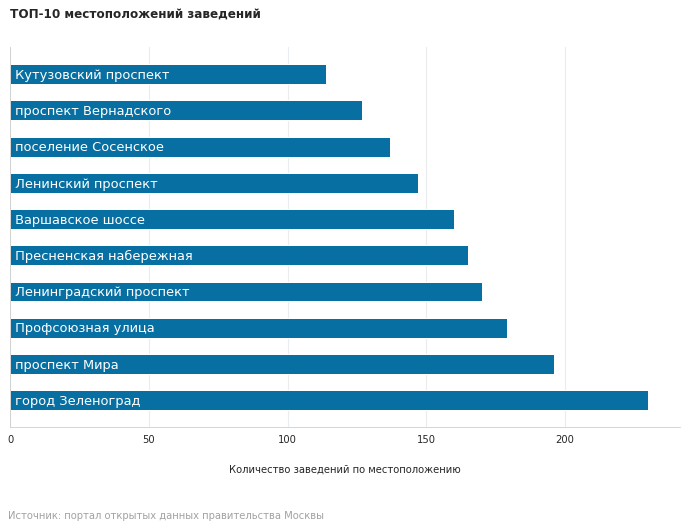

In [61]:
Picasso.horizontal_bar(top_ten_streets, 'street', 'id', labels=labels)

Проверим где расположены адреса:

In [62]:
admo = top_ten_streets.merge(clean_data[['street', 'admo']], on='street').drop_duplicates()
simple_grouper(admo, 'admo')

,admo,id,percent
7,Юго-Западный административный округ,5,23.81
5,Троицкий административный округ,4,19.05
0,Западный административный округ,3,14.29
6,Центральный административный округ,3,14.29
8,Южный административный округ,2,9.52
1,Зеленоградский административный округ,1,4.76
2,Новомосковский административный округ,1,4.76
3,Северный административный округ,1,4.76
4,Северо-Восточный административный округ,1,4.76


&#9889; **Выводы**

1. Пятерка самых загруженных адресов Москвы:
    - город Зеленоград (230, 1.51% от всех заведений).
    - проспект Мира (196, 1.29% от всех заведений).
    - Профсоюзная улица (179, 1.18% от всех заведений).
    - Ленинградский проспект (170, 1.12% от всех заведений).
    - Пресненская набережная (165, 1.09% от всех заведений).


2. Улицы попадают в 8 различных административных округа Москвы (с учетом того, что некоторые улицы находятся в нескольких округах сразу), лидер - Юго-Западный административный округ 5 улиц из 10 (23%).


3. Необходимо отметить, что из 8 округов - 7 находятся за пределами 3 транспортного кольца (исключение - Центральный административный округ, 3 улицы: проспект Мира, Пресненская набережная, Ленинский проспект). Полагаю, это вызвано несколькими факторами: 
    - стоимость аренды квадратного метра коммерческой недвижимости, чем ближе к центру, тем дороже метр - по данным https://domclick.ru/
    - стоимость квадратного метра, в том числе, вызвана нехваткой свободных площадей,
    - большинство работает, учится, проводит свободное время, за пределами 3-его транспортного кольца Москвы - там просто больше людей, как следствие, больше заведений.

[В оглавление](#TOC)

### - проверим улицы с одним заведением, определим районы Москвы

Сгруппируем данные по названию улиц:

In [63]:
only_one_streets = simple_grouper(clean_data, 'street').query('id == 1')
only_one_streets

,street,id,percent
1869,Дербеневская улица,1,0.01
1664,улица Маршала Новикова,1,0.01
1902,улица Обручева,1,0.01
1453,улица Анатолия Живова,1,0.01
1441,улица Академика Павлова,1,0.01
...,...,...,...
926,Парусный проезд,1,0.01
928,Педагогическая улица,1,0.01
929,Пенягинская улица,1,0.01
936,Перовский проезд,1,0.01


Пятьсот восемьдесят пять улиц с одним заведением. Сгруппируем данные, добавим округа и районы:

In [64]:
disticts_for_only_one_streets = only_one_streets.merge(
    clean_data[['street', 'district', 'admo']], on='street')
disticts_for_only_one_streets

,street,id,percent,district,admo
0,Дербеневская улица,1,0.01,Даниловский район,Южный административный округ
1,улица Маршала Новикова,1,0.01,район Щукино,Северо-Западный административный округ
2,улица Обручева,1,0.01,Обручевский район,Юго-Западный административный округ
3,улица Анатолия Живова,1,0.01,Пресненский район,Центральный административный округ
4,улица Академика Павлова,1,0.01,район Кунцево,Западный административный округ
...,...,...,...,...,...
580,Парусный проезд,1,0.01,район Южное Тушино,Северо-Западный административный округ
581,Педагогическая улица,1,0.01,район Бирюлёво Восточное,Южный административный округ
582,Пенягинская улица,1,0.01,район Митино,Северо-Западный административный округ
583,Перовский проезд,1,0.01,район Лефортово,Юго-Восточный административный округ


Посчитаем сколько улиц попали в различные округа:

In [65]:
simple_grouper(disticts_for_only_one_streets, 'admo')

,admo,id,percent
7,Центральный административный округ,188,32.14
0,Восточный административный округ,66,11.28
4,Северо-Восточный административный округ,66,11.28
8,Юго-Восточный административный округ,56,9.57
3,Северный административный округ,54,9.23
1,Западный административный округ,46,7.86
10,Южный административный округ,39,6.67
9,Юго-Западный административный округ,31,5.30
5,Северо-Западный административный округ,30,5.13
2,Новомосковский административный округ,6,1.03


В представленных данных 188 улиц (32% от улиц с одним заведением) попали в Центральный административный округ, еще 66 (11.28%) попали в Восточный административный округ (11.28%) в котором находится, в том числе, парк "Сокольники", а также 66 (11.28%) в Северо-Восточный административный округ. По крайней мере Центральный административный округ и Восточный административный округ (вместе 254 улицы, 43,39%) можно рассматривать как особые районы с высокой стоимостью аренды. Выделим эти округа, чтобы проверить районы:

In [66]:
central_and_east_adm = disticts_for_only_one_streets.query(
    'admo in ["Центральный административный округ", "Восточный административный округ"]')
simple_grouper(central_and_east_adm, 'district').head(10)

,district,id,percent
4,Таганский район,33,12.99
21,район Хамовники,27,10.63
3,Пресненский район,24,9.45
0,Басманный район,22,8.66
5,Тверской район,21,8.27
2,Мещанский район,15,5.91
20,район Сокольники,15,5.91
19,район Соколиная Гора,13,5.12
11,район Замоскворечье,13,5.12
1,Красносельский район,11,4.33


&#9889; **Выводы**

Больше всего улиц с одним заведением в следующих районах Москвы:

- Таганский район
- район Хамовники
- Пресненский район
- Басманный район
- Тверской район

[В оглавление](#TOC)

### - проверим распределение количества посадочных мест для улиц с большим количеством заведений

Используем ранее подготовленный список с топ-10 улиц с наибольшим количеством заведений, отфильтруем таблицу:

In [67]:
top_ten_filtered = clean_data.query('street in @top_ten_streets["street"]')
top_ten_filtered

,id,object_name,chain,object_type,address,number,admo,district,longitude,latitude,oper_name_fixed,city,street
151,155973,Кафе «Андерсон»,да,кафе,"город Москва, Варшавское шоссе, дом 2",150,Южный административный округ,Донской район,37.620336,55.700601,Андерсон,город Москва,Варшавское шоссе
152,23618,Кафе «Subway»,да,кафе,"город Москва, Варшавское шоссе, дом 7, корпус 1",36,Южный административный округ,Донской район,37.622413,55.700884,Subway,город Москва,Варшавское шоссе
153,155852,Кафе «Ламаджо»,нет,кафе,"город Москва, Варшавское шоссе, дом 29",30,Южный административный округ,Донской район,37.622106,55.693234,Кафе «Ламаджо»,город Москва,Варшавское шоссе
154,152556,Шаурма в пите,нет,фастфуд,"город Москва, Варшавское шоссе, дом 72, корпус 2",0,Южный административный округ,Нагорный район,37.618771,55.656839,Шаурма в пите,город Москва,Варшавское шоссе
155,120658,Выпечка,нет,кафетерий,"город Москва, Варшавское шоссе, дом 100",2,Южный административный округ,Нагорный район,37.618975,55.645968,Выпечка,город Москва,Варшавское шоссе
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15292,218439,Милти,да,закусочная,"город Москва, Кутузовский проспект, дом 36, ст...",0,Западный административный округ,район Дорогомилово,37.526339,55.740224,Милти,город Москва,Кутузовский проспект
15307,213629,ДОДО пицца,да,кафе,"город Москва, Пресненская набережная, дом 12",25,Центральный административный округ,Пресненский район,37.537329,55.749668,Додо Пицца,город Москва,Пресненская набережная
15324,198436,Милти,да,фастфуд,"город Москва, Ленинградский проспект, дом 80, ...",0,Северный административный округ,район Сокол,37.510440,55.808233,Милти,город Москва,Ленинградский проспект
15346,222491,Кальянная «Мята Lounge»,да,кафе,"город Москва, Профсоюзная улица, дом 142, корп...",40,Юго-Западный административный округ,район Тёплый Стан,37.509268,55.625521,Мята Lounge,город Москва,Профсоюзная улица


Проверим статистику полученной выборки:

In [68]:
top_ten_filtered[['number']].describe(percentiles=[0.95, 0.99]).T

,count,mean,std,min,50%,95%,99%,max
number,1625.0,57.582769,86.02161,0.0,38.0,180.0,300.0,1700.0


В выборку попало ранее выявленное Arena by Soho Family, которое будет влиять на графики. Исключим данное наблюдение и визуализируем данные:

In [69]:
top_ten_filtered = top_ten_filtered.query('number < 301')

Построим диаграммы размаха для каждой из улиц:

In [70]:
labels = {'xlabel': 'Улица', 
          'ylabel': 'Число посадочных мест',
          'title': 'Распределение посадочных мест в заведениях',
          'source': 'портал открытых данных правительства Москвы'}

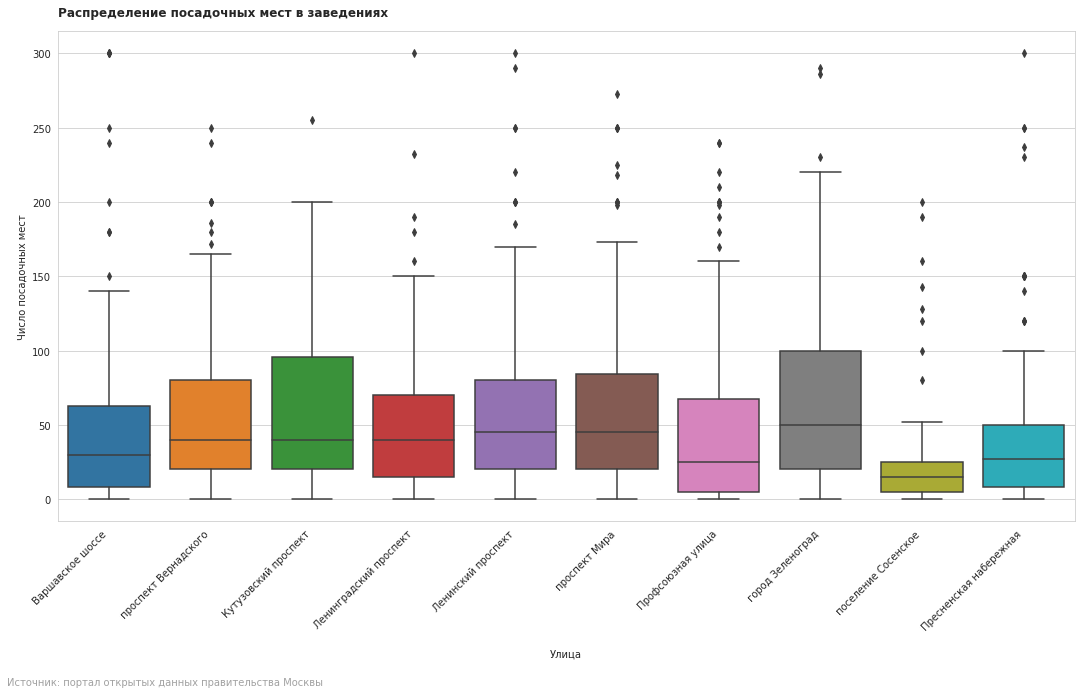

In [71]:
Picasso.boxplotter(top_ten_filtered, ['street', 'number'], labels)

&#9889; **Выводы**

1. По среднему числу посадочных мест лидируют Зеленоград (советская силиконовая долина), Ленинский проспект, Кутузовский проспект, проспект Мира.
2. Среднее число посадочных мест укладывается в общий паттерн - медианное число мест нигде не превышает 50, в большинстве случаев среднее в районе 50.
3. Представляется, на данном этапе уже можно считать количество посадочных мест объективным фактором - возможности выбора площади заведения ограничены их наличием, стоимостью аренды, следующими за расположением.

[В оглавление](#TOC)

## 6) Рекомендации о возможности развития сети<a class="anchor" id="2_6"></a>

1. Принимая во внимание, что заявлен оригинальное условие заведения — гостей должны обслуживать роботы - с некоторой осторожностью можно исключить из потенциальных типов заведения:
    - рестораны, в первую очередь, из-за особенностей публики, "не демократичный" формат заведения, 
    - кулинарии расположены в отделах магазинов - поэтому как возможность можно исключить,
    - кафетерии, столовые, буфеты, закусочные, бары: представляются не окупаемыми, опять таки из-за публики, размеров, слишком "демократичного" формата заведения.


2. Как следствие, под заявленную особенность подходит кафе, а также, с оговорками, фастфуд (отчасти, крайне специфический вид таких "роботов" - вендинговые автоматы).

3. Для кафе можно предложить футуристический стиль, но не как в Футураме, а в духе "Джетсонов", "Назад в будущее".

4. Опираясь на представленные данные, в отсутствии финансовых параметров, с осторожностью, можно ориентироваться на 30 посадочных мест.

5. В качестве района расположения, исходя из представленных данных, с учетом специфики заведения, рекомендовано ориентироваться на Тверской, Басманный, Пресненский районы, Мещанский, Даниловский районы, Замоскворечье - районы должны обеспечивать хорошую проходимость, в этих районах заведения сконцентрированы мене плотно, чем в других. Кроме того, возможно, при составлении финансовой модели стоит учесть Зеленоград - как один из основных научно-производственных центров советской и российской электроники и микроэлектроники. 

[В оглавление](#TOC)

## Выводы по итогам анализа данных<a class="anchor" id="2_conclusion"></a>

1. В представленных данных заметно выделяются четыре категории: с большим отрывом представлены кафе 6 012 (39.59%), далее идут столовые - 2 575 (16.96%), рестораны - 2 274 (14.97%), фастфуды - 1889 (12.44%). Остальные заведения занимают менее 6%: самый многочисленный тип - бары (852, 5.61%), менее всего в данных наблюдений об отделах кулинарии в магазинах (272, 1.79%).
2. В данных представлено девять типов заведений - от отделов кулинарии в магазинах до ресторанов.
3. Заметно выделяются четыре категории: кафе 6 012 (39.59%), столовые - 2 575 (16.96%), рестораны - 2 274 (14.97%), фастфуды - 1889 (12.44%). Остальные заведения занимают менее 6%.
4. В представленных данных сетевыми являются:
    - 41% от всех фастфуда,
    - 29% от всех отделов кулинарии,
    - 24% от всех ресторанов,
    - 16% от закусочных,
    - 13% от кафетериев.
<br></br>
5.В 99% всех заведений не более 300 посадочных мест. В 95% всех заведений не более 218 посадочных мест. Если проверять отдельно сетевые и несетевые заведения - числовые средние двух выборок близки друг к другу, медиана совпадает. Вместе с тем, среднее число мест сетевых и несетевых заведений имеет статистически значимые различия.
6. Принимая во внимание общую статистку, визуальное представление и результаты статистических тестов есть основания рассматривать сетевые и несетевые заведения как самостоятельные явления - сетевые заведения отличаются от несетевых.
7. Пять самых крупных сетей:
    - Шоколадница (178 заведений, 6.05% от числа сетевых заведений,
    - KFC (175 заведений, 5.95% от числа сетевых заведений),
    - Макдоналдс (168 заведений, 5.71% от числа сетевых заведений),
    - Бургер Кинг (158 заведений, 5.37% от числа сетевых заведений),
    - Теремок (111 заведений, 3.74% от числа сетевых заведений). 
<br></br>      
8. В пяти самых крупных сетях среднее число посадочных мест:
    - Шоколадница - 58,
    - KFC - 54,
    - Макдоналдс - 89,
    - Бургер Кинг - 48,
    - Теремок - 27.
<br></br>
9. Выявлено, что большинство сетевых заведений представлено в количестве от 1 до 10, чаще всего с числом посадочных мест в диапазоне от 15 до 45, то несмотря на несколько доминирующих сетей - в целом, большинство сетей оперируют сравнительно небольшим числом посадочных мест и количеством заведений.
10. Тип заведения вляиет на среднее количество мест. В среднем, больше мест в столовых и ресторанах - 112 (при медиане 120), 100 (при медиане 90), соответственно. Кроме того, выделяется группа с барами, кафе и фастфудами со средним в диапазоне от 53 до 40.
11. Пятерка самых загруженных улиц и пригородов Москвы:
    - город Зеленоград (230, 1.51% от всех заведений).
    - проспект Мира (196, 1.29% от всех заведений).
    - Профсоюзная улица (179, 1.18% от всех заведений).
    - Ленинградский проспект (170, 1.12% от всех заведений).
    - Пресненская набережная (165, 1.09% от всех заведений).

12. Улицы попадают в 8 различных административных округа Москвы (с учетом того, что некоторые улицы народятся в нескольких округах сразу), лидер - Юго-Западный административный округ 5 улиц из 10 (23%). Из 8 округов - 7 находятся за пределами 3 транспортного кольца (исключение - Центральный административный округ, 3 улицы: проспект Мира, Пресненская набережная, Ленинский проспект). 
13. Больше всего улиц с одним заведением в следующих районах Москвы:
    - Таганский район
    - район Хамовники
    - Пресненский район
    - Басманный район
    - Тверской район
<br></br>
14. По среднему числу посадочных мест лидируют Зеленоград, Ленинский проспект, Кутузовский проспект, проспект Мира. Среднее число посадочных мест укладывается в общий паттерн - медианное число мест нигде не превышает 50, в большинстве случаев среднее в районе 50.
15. Принимая во внимание, что заявлен оригинальное условие заведения — гостей должны обслуживать роботы - с некоторой осторожностью можно рекомендовать избрать кафе как тип заведения, предложить футуристический стиль, но не как в Футураме, а в духе "Джетсонов", "Назад в будущее", ориентироваться на 30 посадочных мест.
16. В качестве района расположения, исходя из представленных данных, с учетом специфики заведения, рекомендовано ориентироваться на Тверской, Басманный, Пресненский районы, Мещанский, Даниловский районы, Замоскворечье - районы должны обеспечивать хорошую проходимость, в этих районах заведения сконцентрированы мене плотно, чем в других. Кроме того, возможно, при составлении финансовой модели стоит учесть Зеленоград - как один из основных научно-производственных центров советской и российской электроники и микроэлектроники.


[В оглавление](#TOC)